# Project 1. 중고차 시세 예측
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

## P1-1. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

# 한글 나눔포트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 모델 수립을 위한 Train/Validation Set
df = pd.read_csv('/content/drive/MyDrive/ADX/P1_dataset.csv', index_col=0, encoding ='cp949')  # 한글 Encoding 문제로 encoding = 'cp949'

# 시스템 구현을 위한 Test Set 샘플
df_test = pd.read_csv('/content/drive/MyDrive/ADX/P1_testset_sample.csv', index_col=0,encoding ='cp949')  # 한글 Encoding 문제로 encoding = 'cp949'

Mounted at /content/drive
[Errno 107] Transport endpoint is not connected: 'drive/My Drive'
/content/drive/My Drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
cp: failed to access '../../': Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberati

## P1-2. Modelling
- df를 사용하여 예측모형 수립
- 상세 사항은 업로드 된 비디오 참고

In [ ]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('font', family='GULIM')

# General Preprocessing

In [ ]:
target = ['SUCCPRIC']

ETC_list = ['SUCCYMD', 'CARNM', 'CHASNO', 'CARREGIYMD', 'YEAR']

continous_list = ['EXHA', 'TRAVDIST']

price_list = ['NEWCARPRIC', 'SHIPPING_PRICE', 'NC_GRADE_PRICE']

discrete_list = ['MISSNM', 'FUELNM', 'COLOR', 'USEUSENM', 'OWNECLASNM', 'INNEEXPOCLASCD_YN']

key_list = ['MF_KEY', 'MJ_MODEL_KEY', 'DT_MODEL_KEY', 'MJ_GRADE_KEY', 'DT_GRADE_KEY', 'NC_GRADE_KEY']

one_hot_list = ['YEARCHK', 'BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR',
                'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL', 'LEFT_STEP', 'RIGHT_STEP',
                'LEFT_FILER_A', 'RIGHT_FILER_A', 'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C',
                'RIGHT_FILER_C', 'LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'BACK_PANEL1', 'LEFT_INSIDE_PANEL',
                'RIGHT_INSIDE_PANEL', 'LEFT_WHEEL_HOUSE', 'RIGHT_WHEEL_HOUSE', 'LEFT_INSIDE_WHEEL_HOUSE',
                'RIGHT_INSIDE_WHEEL_HOUSE', 'LEFT_REAR_WHEEL_HOUSE', 'RIGHT_REAR_WHEEL_HOUSE', 'TRUNK_FLOOR',
                'DASH_PANEL', 'SHEET_PANEL', 'SIDE_MEMBER_FRAME', 'LEFT_QUARTER', 'RIGHT_QUARTER',
                'FLOOR_PANEL', 'LEFT_SIDE_PANEL', 'RIGHT_SIDE_PANEL', 'LEFT_REAR_CORNER_PANEL',
                'RIGHT_REAR_CORNER_PANEL', 'BACK_PANEL2', 'LEFT_CORNER_PANEL', 'RIGHT_CORNER_PANEL',
                'LEFT_SKIRT_PANEL', 'RIGHT_SKIRT_PANEL', 'SIDE_MEMBER_FRAME2', 'LEFT_INSIDE_SHEETING',
                'RIGHT_INSIDE_SHEETING', 'LEFT_WHEEL_HOUSE_SHEETING', 'RIGHT_WHEEL_HOUSE_SHEETING',
                'LEFT_REAR_INSIDE_PANEL_SHEETING', 'RIGHT_REAR_INSIDE_PANEL_SHEETING',
                'LEFT_REAR_WHEEL_HOUSE_SHEETING', 'RIGHT_REAR_WHEEL_HOUSE_SHEETING', 'TRUNK_FLOOR_SHEETING',
                'DASH_PANEL_SHEETING', 'SHEET_BACK_PANEL_SHEETING', 'SIDE_MEMBER_FRAME_SHEETING',
                'FLOOR_PANEL_SHEETING', 'LEFT_SIDE_PANEL_SHEETING', 'RIGHT_SIDE_PANEL_SHEETING',
                'FLOODING', 'TOTAL_LOSS', 'JOINCAR', 'NOTAVAILABLE', 'ABS', 'AB2', 'NAVIGATION', 'VDC', 'SMARTKEY',
                'SUNLOOPPANORAMA', 'SUNLOOPCOMMON', 'SUNLOOPDUAL', 'DIS', 'TCS', 'AB1', 'ETC', 'AV', 'EPS', 'ECS']

# Train Test 분리

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Train 이산형 결측치처리 파트

In [ ]:
# train에 대해 먼저 전처리
df_1 = train.copy()
df_1 = df_1.drop(df_1[df_1['FUELNM'].isna() == True].index)
df_1 = df_1.drop(df_1[df_1['OWNECLASNM'].isna() == True].index)
df_1 = df_1.drop(df_1[df_1['CARREGIYMD'].isna() == True].index)

# df_1.loc[df_1['OWNECLASNM'].isna(), 'OWNECLASNM'] = '기타'
condition = (df_1['OWNECLASNM'] == '개인') & (df_1['USEUSENM'].isna())
df_1.loc[condition, 'USEUSENM'] = '자가'
df_1.loc[df_1['USEUSENM'].isna(), 'USEUSENM'] = '기타'

# Train 연속형 결측치처리 파트

In [ ]:
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].replace(0, np.nan)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].replace(1, np.nan)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].apply(lambda x: np.nan if x < 1000 else x)

In [ ]:
model = df_1['MJ_MODEL_KEY'].astype(str)+"-"+df_1['DT_MODEL_KEY'].astype(str)
df_1.insert(15, 'MODEL', model)
# 모델 별 평균 가격
price_model = df_1.groupby('MODEL')['NEWCARPRIC'].median()
price_model2 = df_1.groupby('MODEL')['SHIPPING_PRICE'].median()
price_model3 = df_1.groupby('MODEL')['NC_GRADE_PRICE'].median()

price_model = dict(price_model)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].fillna(df_1.MODEL.map(price_model))
price_model2 = dict(price_model2)
df_1['SHIPPING_PRICE'] = df_1['SHIPPING_PRICE'].fillna(df_1.MODEL.map(price_model2))
price_model3 = dict(price_model3)
df_1['NC_GRADE_PRICE'] = df_1['NC_GRADE_PRICE'].fillna(df_1.MODEL.map(price_model3))

In [ ]:
for price in price_list:
    mode = df_1[price].mode()[0]
    df_1[price] = df_1[price].fillna(mode)

# Train 이상치제거 파트

In [ ]:
df_2 = df_1.copy()
df_2['NEWCARPRIC'] = winsorize(df_2['NEWCARPRIC'], limits=[0.001, 0.001])

# Train 파생변수 파트

In [ ]:
df_3 = df_2.copy()

# SUCCYMD(낙찰일자) - CARREGIYMD(차량등록일) 을 새로운 변수 Days로 저장
df_3['SUCCYMD'] = pd.to_datetime(df_3['SUCCYMD'], format='%Y%m%d')
df_3['CARREGIYMD'] = pd.to_datetime(df_3['CARREGIYMD'], format='%Y%m%d')
df_3['Days'] = (df_3['SUCCYMD'] - df_3['CARREGIYMD']).dt.days.astype(int)

In [ ]:
outer_frame = [
    'BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR',
    'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL', 'LEFT_STEP', 'RIGHT_STEP',
    'LEFT_FILER_A', 'RIGHT_FILER_A', 'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C', 'RIGHT_FILER_C',
    'LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'BACK_PANEL1', 'LEFT_QUARTER', 'RIGHT_QUARTER',
    'BACK_PANEL2', 'LEFT_CORNER_PANEL', 'RIGHT_CORNER_PANEL', 'LEFT_SKIRT_PANEL', 'RIGHT_SKIRT_PANEL'
]

# Outer_frame에 해당하는 값이 1이 하나라도 있으면 1, 없으면 0으로 설정
df_3['Accident'] = df_3[outer_frame].max(axis=1)

In [ ]:
##사고 유형 분류
# 외판부위 1랭크
outer_panels_rank1 = ['BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR',
                      'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL']

# 외판부위 2랭크
outer_panels_rank2 = ['LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'LEFT_QUARTER', 'RIGHT_QUARTER']

# 주요골격 A랭크
main_frame_rankA = ['FRONT_PANNEL', 'TRUNK_FLOOR', 'LEFT_INSIDE_PANEL', 'RIGHT_INSIDE_PANEL']

# 주요골격 B랭크
main_frame_rankB = ['SIDE_MEMBER_FRAME', 'LEFT_WHEEL_HOUSE', 'RIGHT_WHEEL_HOUSE', 'LEFT_FILER_A', 'RIGHT_FILER_A',
                    'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C', 'RIGHT_FILER_C']

# 주요골격 C랭크
main_frame_rankC = ['DASH_PANEL', 'FLOOR_PANEL']

# 외판, 골격 세분화
df_3['outer_1'] = df_3[outer_panels_rank1].sum(axis=1)
df_3['outer_2'] = df_3[outer_panels_rank2].sum(axis=1)
df_3['main_A'] = df_3[main_frame_rankA].sum(axis=1)
df_3['main_B'] = df_3[main_frame_rankB].sum(axis=1)
df_3['main_C'] = df_3[main_frame_rankC].sum(axis=1)

In [ ]:
selected_columns = ['MJ_GRADE_KEY', 'DT_GRADE_KEY', 'NC_GRADE_KEY']

for col in selected_columns:
    # 'SUCCPRIC'의 평균을 계산하여 새로운 열 생성
    mean_suuccpric_by_col = df_3.groupby(col)['SUCCPRIC'].mean().reset_index()
    mean_suuccpric_by_col.columns = [col, f'SUCCPRIC_MEAN_{col}']

    # 각 열을 기준으로 평균값을 매핑하여 원래 데이터프레임에 추가
    df_3 = pd.merge(df_3, mean_suuccpric_by_col, on=col, how='left')

# 구간을 정의하고 각 카테고리를 구간에 따라 인코딩
bins = [0, 12000000, 24000000, 36000000, 48000000, np.inf]
labels_MJ = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_MJ_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_MJ_GRADE_KEY'], bins=bins, labels=labels_MJ)
labels_DT = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_DT_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_DT_GRADE_KEY'], bins=bins, labels=labels_DT)
labels_NC = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_NC_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_NC_GRADE_KEY'], bins=bins, labels=labels_NC)

# Train 범주형인코딩 파트

In [ ]:
df_4 = df_3.copy()

selected_columns = ['FUELNM', 'USEUSENM', 'OWNECLASNM']
label_encoders = {}
for column in selected_columns:
    le = LabelEncoder()
    df_4[column] = le.fit_transform(df_4[column])
    label_encoders[column] = le

onehot_list = ['YEARCHK', 'INNEEXPOCLASCD_YN']
df_4 = pd.get_dummies(df_4, columns=onehot_list)

missnm_order = ['M/T', 'CVT', 'A/T']
encoder = OrdinalEncoder(categories=[missnm_order])
df_4['MISSNM'] = encoder.fit_transform(df_4[['MISSNM']])

color_order = ['B', 'C', 'A', 'D', 'F']
encoder = OrdinalEncoder(categories=[color_order])
df_4['COLOR'] = encoder.fit_transform(df_4[['COLOR']])

df_4 = df_4.drop(columns=['SUCCYMD', 'CARNM', 'CHASNO', 'CARREGIYMD', 'YEAR', 'MODEL'])

In [ ]:
df_4['FRONT_FENDER'] = df_4['FRONT_LEFT_FENDER'] + df_4['FRONT_RIGHT_FENDER']
df_4['FRONT_DOOR'] = df_4['FRONT_LEFT_DOOR'] + df_4['FRONT_RIGHT_DOOR']
df_4['BACK_DOOR'] = df_4['FRONT_LEFT_DOOR'] + df_4['FRONT_RIGHT_DOOR']
df_4 = df_4.drop(['FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR', 'BACK_LEFT_DOOR',
                  'BACK_RIGHT_DOOR'], axis=1)

new_one_hot_list = ['SKIRT_PANEL', 'REAR_INSIDE_PANEL_SHEETING', 'STEP', 'FILER_A', 'WHEEL_HOUSE',
                    'SIDE_PANEL_SHEETING',
                    'INSIDE_SHEETING', 'REAR_WHEEL_HOUSE_SHEETING', 'QUARTER', 'INSIDE_WHEEL_HOUSE', 'REAR_WHEEL_HOUSE',
                    'WHEEL_HOUSE_SHEETING', 'REAR_CORNER_PANEL', 'FILER_B', 'FILER_C', 'CORNER_PANEL', 'REAR_FENDER',
                    'INSIDE_PANEL', 'SIDE_PANEL']

for item in new_one_hot_list:
    left_col = f'LEFT_{item}'
    right_col = f'RIGHT_{item}'
    new_col_name = item

    df_4[new_col_name] = df_4[left_col] + df_4[right_col]
    df_4 = df_4.drop([left_col, right_col], axis=1)

# df_4[new_one_hot_list][df_4[new_one_hot_list]==2]=1

In [ ]:
to_list=['SUCCPRIC_MEAN_MJ_GRADE_KEY','SUCCPRIC_MEAN_DT_GRADE_KEY','SUCCPRIC_MEAN_NC_GRADE_KEY']
for col in to_list:
    df_4[col]=df_4[col].astype(int)

In [ ]:
def map_bool_to_int(value):
    return int(value)


for column in df_4.columns:
    if df_4[column].dtype == bool:
        df_4[column] = df_4[column].map(map_bool_to_int)

X = df_4.drop(columns='SUCCPRIC')
y = df_4['SUCCPRIC']

# Train 연속형변수 분포저장

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
def standard_scale_train(train_data, feature_names):
    """
    특정 feature들에 대해 Z 정규화를 수행하는 함수, sklearn의 StandardScaler 사용
    :param train_data: 훈련 데이터셋 (DataFrame)
    :param feature_names: 정규화를 수행할 특성들의 리스트
    :return: 정규화된 훈련 데이터셋, 훈련된 StandardScaler 객체
    """
    scaler = StandardScaler()
    train_data_scaled = train_data.copy()
    train_data_scaled[feature_names] = scaler.fit_transform(train_data[feature_names])
    return train_data_scaled, scaler


def standard_scale_val(X_val, feature_names, scaler):
    """
    validation set을 특정 feature들에 대해 Z 정규화하는 함수, sklearn의 StandardScaler 사용
    :param X_val: validation set (DataFrame)
    :param feature_names: 정규화를 수행할 특성들의 리스트
    :param scaler: 훈련 데이터셋에 대해 훈련된 StandardScaler 객체
    :return: 정규화된 validation set
    """
    X_val_scaled = X_val.copy()
    X_val_scaled[feature_names] = scaler.transform(X_val[feature_names])
    return X_val_scaled

In [ ]:
# # 위 block에서 만들어진 z_normalize와 z_normalize_val 적용 (Error 날 경우 다시 고민할 것)
X_train_norm = X_train.copy()
X_train_norm.loc[:, continous_list + price_list], scaler = standard_scale_train(X_train, continous_list + price_list)
X_val_norm = X_val.copy()
X_val_norm.loc[:, continous_list + price_list] = standard_scale_val(X_val, continous_list + price_list, scaler)

# 전처리 성능체크

In [ ]:
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train_norm, y_train)
dt_pred = model_dt.predict(X_val_norm)
mse = mean_squared_error(y_val, dt_pred)
mae = mean_absolute_error(y_val, dt_pred)
r2 = r2_score(y_val, dt_pred)
print('DT')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

DT
MSE: 1703069124893.7979
MAE: 848265.0807136788
R^2: 0.9608366084256332


# 모델 훈련 파트

1
2
3


Best Hyperparameters for Decision Tree with Hyperparameters:  {'max_depth': 30, 'max_features': 0.7}
Best MSE for Decision Tree with Hyperparameters:  1654990157117.3228


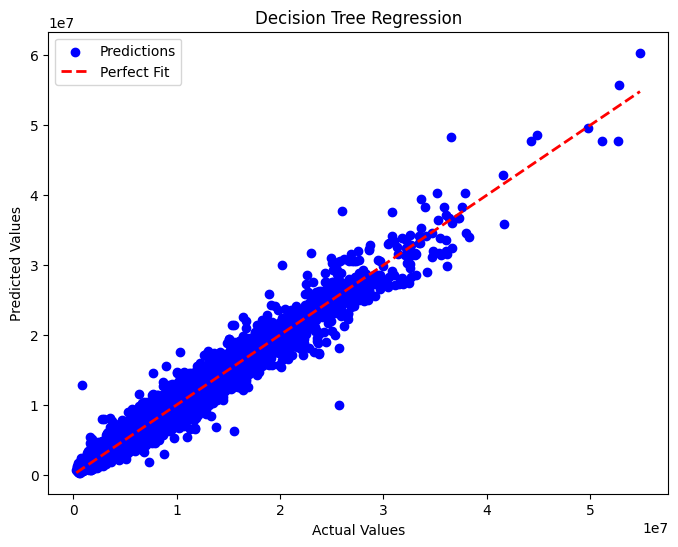

In [ ]:
best_dt = None
best_dt_mse = 1e20
best_dt_hyperparameter = None
max_depths = [30, 40, 50]
max_features = [0.3, 0.5, 0.7]

i = 0
for depth in max_depths:
    i += 1
    print(i)
    for feature in max_features:
      dt = DecisionTreeRegressor(max_depth=depth, random_state=42, max_features=feature)
      dt.fit(X_train_norm, y_train)
      y_pred = dt.predict(X_val_norm)
      mse = mean_squared_error(y_val, y_pred)

      best_dt=dt

      # 최적의 모델인지 확인
      if mse < best_dt_mse:
          best_dt = dt
          best_dt_mse = mse
          best_dt_hyperparameter = {'max_depth': depth, 'max_features': feature}

# 해당 hyperparameter 출력
print("Best Hyperparameters for Decision Tree with Hyperparameters: ", best_dt_hyperparameter)
print("Best MSE for Decision Tree with Hyperparameters: ", best_dt_mse)

# Regression 결과 시각화
y_pred = best_dt.predict(X_val_norm)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2,
         label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

1
2
3
Best Hyperparameters for Random Forest with Varying Hyperparameters:  {'n_estimators': 150, 'max_depth': 50}
Best MSE for Random Forest with Varying Hyperparameters:  830588272043.0474


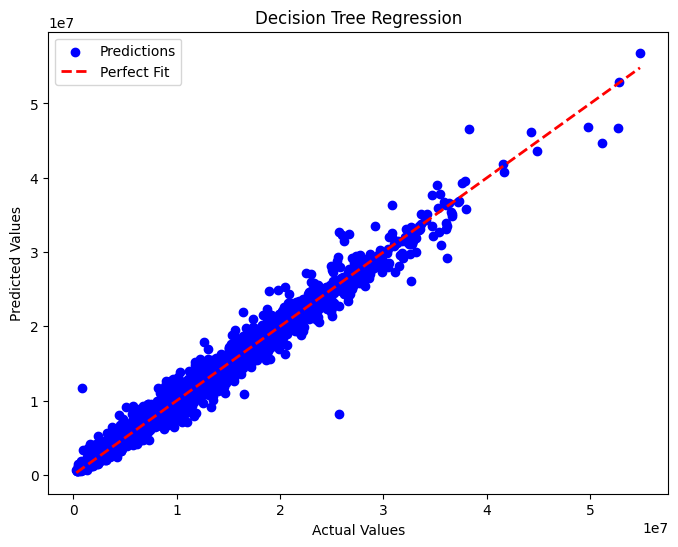

In [ ]:
best_rf = None
best_rf_mse = 1e20
best_rf_hyperparameter = None
n_estimators = [50, 100, 150]
max_depths = [50, 75, 100]

i = 0
for estimator in n_estimators:
    i += 1
    print(i)
    for depth in max_depths:
        rf = RandomForestRegressor(max_depth=depth, n_estimators=estimator, random_state=42)
        rf.fit(X_train_norm, y_train)
        y_pred = rf.predict(X_val_norm)
        mse = mean_squared_error(y_val, y_pred)

        best_rf = rf

        # 최적의 모델인지 확인
        if mse < best_rf_mse:
            best_rf = rf
            best_rf_mse = mse
            best_rf_hyperparameter = {'n_estimators': estimator,
                                      'max_depth': depth}

# 해당 hyperparameter 출력
print("Best Hyperparameters for Random Forest with Varying Hyperparameters: ", best_rf_hyperparameter)
print("Best MSE for Random Forest with Varying Hyperparameters: ", best_rf_mse)

# Regression 결과 시각화
y_pred = best_rf.predict(X_val_norm)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2,
         label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

1
2
3
Best Hyperparameters for Adaboost with Hyperparameters:  {'n_estimators': 150, 'max_depth': 30}
Best MSE for Adaboost with Hyperparameters:  814319583597.3599


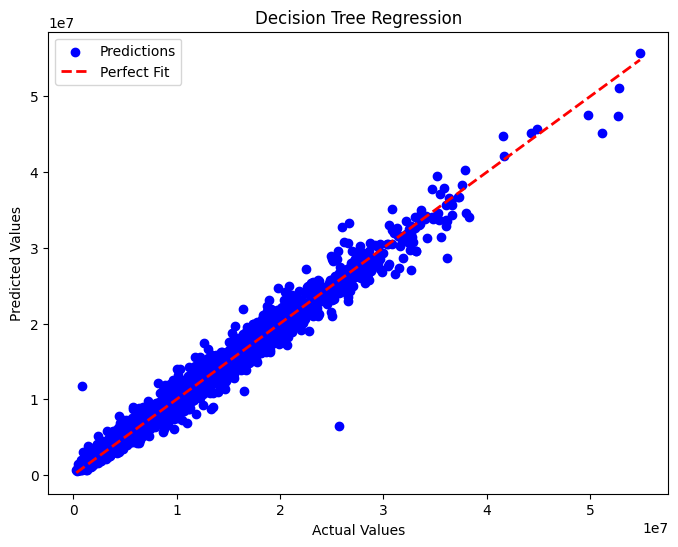

In [ ]:
best_ad = None
best_ad_mse = 1e20
best_ad_hyperparameter = None
n_estimators = [50, 100, 150]
max_depths = [5, 10, 30]

i = 0
for depth in max_depths:
    i += 1
    print(i)
    for estimator in n_estimators:
        base_estimator = DecisionTreeRegressor(max_depth=depth)
        ad = AdaBoostRegressor(base_estimator, n_estimators=estimator)
        ad.fit(X_train_norm, y_train)
        y_pred = ad.predict(X_val_norm)
        mse = mean_squared_error(y_val, y_pred)

        best_ad = ad

        # 최적의 모델인지 확인
        if mse < best_ad_mse:
            best_ad = ad
            best_ad_mse = mse
            best_ad_hyperparameter = {'n_estimators': estimator,
                                      'max_depth': depth}

# 해당 hyperparameter 출력
print("Best Hyperparameters for Adaboost with Hyperparameters: ", best_ad_hyperparameter)
print("Best MSE for Adaboost with Hyperparameters: ", best_ad_mse)

# Regression 결과 시각화
y_pred = best_ad.predict(X_val_norm)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2,
         label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

# 모델성능 체크

In [ ]:
dt_pred = best_dt.predict(X_val_norm)
rf_pred = best_rf.predict(X_val_norm)
ad_pred = best_ad.predict(X_val_norm)

model_dict = {'DT': dt_pred, 'RF': rf_pred, 'AD': ad_pred}

for _, name in enumerate(model_dict):
    mse = mean_squared_error(y_val, model_dict[name])
    mae = mean_absolute_error(y_val, model_dict[name])
    r2 = r2_score(y_val, model_dict[name])
    print(name)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R^2: {r2}')

DT
MSE: 1752789294817.3323
MAE: 877736.6185216652
R^2: 0.9596932546677633
RF
MSE: 830588272043.0474
MAE: 584609.5157179269
R^2: 0.9808999803592077
AD
MSE: 814319583597.3599
MAE: 576971.0987398329
R^2: 0.9812740914312051


# Test 이산형 결측치처리 파트

In [ ]:
df_1 = df_test.copy()
# df_1 = test.copy()

df_1 = df_1.drop(df_1[df_1['FUELNM'].isna() == True].index)
df_1 = df_1.drop(df_1[df_1['OWNECLASNM'].isna() == True].index)
df_1 = df_1.drop(df_1[df_1['CARREGIYMD'].isna() == True].index)

# df_1.loc[df_1['OWNECLASNM'].isna(), 'OWNECLASNM'] = '기타'
condition = (df_1['OWNECLASNM'] == '개인') & (df_1['USEUSENM'].isna())
df_1.loc[condition, 'USEUSENM'] = '자가'
df_1.loc[df_1['USEUSENM'].isna(), 'USEUSENM'] = '기타'

# Test 연속형 결측치처리 파트

In [ ]:
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].replace(0, np.nan)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].replace(1, np.nan)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].apply(lambda x: np.nan if x < 1000 else x)

In [ ]:
model = df_1['MJ_MODEL_KEY'].astype(str)+"-"+df_1['DT_MODEL_KEY'].astype(str)
df_1.insert(15, 'MODEL', model)
# 모델 별 평균 가격
price_model = df_1.groupby('MODEL')['NEWCARPRIC'].median()
price_model2 = df_1.groupby('MODEL')['SHIPPING_PRICE'].median()
price_model3 = df_1.groupby('MODEL')['NC_GRADE_PRICE'].median()

price_model = dict(price_model)
df_1['NEWCARPRIC'] = df_1['NEWCARPRIC'].fillna(df_1.MODEL.map(price_model))
price_model2 = dict(price_model2)
df_1['SHIPPING_PRICE'] = df_1['SHIPPING_PRICE'].fillna(df_1.MODEL.map(price_model2))
price_model3 = dict(price_model3)
df_1['NC_GRADE_PRICE'] = df_1['NC_GRADE_PRICE'].fillna(df_1.MODEL.map(price_model3))

In [ ]:
for price in price_list:
    mode = df_1[price].mode()[0]
    df_1[price] = df_1[price].fillna(mode)

# Test 이상치제거 파트

In [ ]:
df_2 = df_1.copy()
df_2['NEWCARPRIC'] = winsorize(df_2['NEWCARPRIC'], limits=[0.001, 0.001])

# Test 파생변수 파트

In [ ]:
df_3 = df_2.copy()

# SUCCYMD(낙찰일자) - CARREGIYMD(차량등록일) 을 새로운 변수 Days로 저장
df_3['SUCCYMD'] = pd.to_datetime(df_3['SUCCYMD'], format='%Y%m%d')
df_3['CARREGIYMD'] = pd.to_datetime(df_3['CARREGIYMD'], format='%Y%m%d')
df_3['Days'] = (df_3['SUCCYMD'] - df_3['CARREGIYMD']).dt.days.astype(int)

In [ ]:
outer_frame = [
    'BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR',
    'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL', 'LEFT_STEP', 'RIGHT_STEP',
    'LEFT_FILER_A', 'RIGHT_FILER_A', 'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C', 'RIGHT_FILER_C',
    'LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'BACK_PANEL1', 'LEFT_QUARTER', 'RIGHT_QUARTER',
    'BACK_PANEL2', 'LEFT_CORNER_PANEL', 'RIGHT_CORNER_PANEL', 'LEFT_SKIRT_PANEL', 'RIGHT_SKIRT_PANEL'
]

# Outer_frame에 해당하는 값이 1이 하나라도 있으면 1, 없으면 0으로 설정
df_3['Accident'] = df_3[outer_frame].max(axis=1)

In [ ]:
# ##사고 유형 분류
# 외판부위 1랭크
outer_panels_rank1 = ['BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR',
                      'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL']

# 외판부위 2랭크
outer_panels_rank2 = ['LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'LEFT_QUARTER', 'RIGHT_QUARTER']

# 주요골격 A랭크
main_frame_rankA = ['FRONT_PANNEL', 'TRUNK_FLOOR', 'LEFT_INSIDE_PANEL', 'RIGHT_INSIDE_PANEL']

# 주요골격 B랭크
main_frame_rankB = ['SIDE_MEMBER_FRAME', 'LEFT_WHEEL_HOUSE', 'RIGHT_WHEEL_HOUSE', 'LEFT_FILER_A', 'RIGHT_FILER_A',
                    'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C', 'RIGHT_FILER_C']

# 주요골격 C랭크
main_frame_rankC = ['DASH_PANEL', 'FLOOR_PANEL']

# 외판, 골격 세분화
df_3['outer_1'] = df_3[outer_panels_rank1].sum(axis=1)
df_3['outer_2'] = df_3[outer_panels_rank2].sum(axis=1)
df_3['main_A'] = df_3[main_frame_rankA].sum(axis=1)
df_3['main_B'] = df_3[main_frame_rankB].sum(axis=1)
df_3['main_C'] = df_3[main_frame_rankC].sum(axis=1)

In [ ]:
selected_columns = ['MJ_GRADE_KEY', 'DT_GRADE_KEY', 'NC_GRADE_KEY']

for col in selected_columns:
    # 'SUCCPRIC'의 평균을 계산하여 새로운 열 생성
    mean_suuccpric_by_col = df_3.groupby(col)['SUCCPRIC'].mean().reset_index()
    mean_suuccpric_by_col.columns = [col, f'SUCCPRIC_MEAN_{col}']

    # 각 열을 기준으로 평균값을 매핑하여 원래 데이터프레임에 추가
    df_3 = pd.merge(df_3, mean_suuccpric_by_col, on=col, how='left')

# 구간을 정의하고 각 카테고리를 구간에 따라 인코딩
bins = [0, 12000000, 24000000, 36000000, 48000000, np.inf]
labels_MJ = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_MJ_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_MJ_GRADE_KEY'], bins=bins, labels=labels_MJ)
labels_DT = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_DT_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_DT_GRADE_KEY'], bins=bins, labels=labels_DT)
labels_NC = [0, 1, 2, 3, 4]
df_3['SUCCPRIC_MEAN_NC_GRADE_KEY'] = pd.cut(df_3['SUCCPRIC_MEAN_NC_GRADE_KEY'], bins=bins, labels=labels_NC)

# Test 범주형인코딩 파트


In [ ]:
df_4 = df_3.copy()

selected_columns = ['FUELNM', 'USEUSENM', 'OWNECLASNM']

for column in selected_columns:
    le=label_encoders[column]
    df_4[column] = [label if label in le.classes_ else 'unknown' for label in df_4[column]]
    le.classes_ = np.append(le.classes_, 'unknown')  # 'unknown' 레이블 추가
    df_4[column] = le.transform(df_4[column])

onehot_list = ['YEARCHK', 'INNEEXPOCLASCD_YN']
df_4 = pd.get_dummies(df_4, columns=onehot_list)

missnm_order = ['M/T', 'CVT', 'A/T']
encoder = OrdinalEncoder(categories=[missnm_order])
df_4['MISSNM'] = encoder.fit_transform(df_4[['MISSNM']])

color_order = ['B', 'C', 'A', 'D', 'F']
encoder = OrdinalEncoder(categories=[color_order])
df_4['COLOR'] = encoder.fit_transform(df_4[['COLOR']])

df_4 = df_4.drop(columns=['SUCCYMD', 'CARNM', 'CHASNO', 'CARREGIYMD', 'YEAR'])

In [ ]:
df_4['FRONT_FENDER'] = df_4['FRONT_LEFT_FENDER'] + df_4['FRONT_RIGHT_FENDER']
df_4['FRONT_DOOR'] = df_4['FRONT_LEFT_DOOR'] + df_4['FRONT_RIGHT_DOOR']
df_4['BACK_DOOR'] = df_4['FRONT_LEFT_DOOR'] + df_4['FRONT_RIGHT_DOOR']
df_4 = df_4.drop(['FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR', 'BACK_LEFT_DOOR',
                  'BACK_RIGHT_DOOR'], axis=1)

new_one_hot_list = ['SKIRT_PANEL', 'REAR_INSIDE_PANEL_SHEETING', 'STEP', 'FILER_A', 'WHEEL_HOUSE',
                    'SIDE_PANEL_SHEETING',
                    'INSIDE_SHEETING', 'REAR_WHEEL_HOUSE_SHEETING', 'QUARTER', 'INSIDE_WHEEL_HOUSE', 'REAR_WHEEL_HOUSE',
                    'WHEEL_HOUSE_SHEETING', 'REAR_CORNER_PANEL', 'FILER_B', 'FILER_C', 'CORNER_PANEL', 'REAR_FENDER',
                    'INSIDE_PANEL', 'SIDE_PANEL']

for item in new_one_hot_list:
    left_col = f'LEFT_{item}'
    right_col = f'RIGHT_{item}'
    new_col_name = item

    df_4[new_col_name] = df_4[left_col] + df_4[right_col]
    df_4 = df_4.drop([left_col, right_col], axis=1)

# df_4[new_one_hot_list][df_4[new_one_hot_list]==2]=1

In [ ]:
to_list=['SUCCPRIC_MEAN_MJ_GRADE_KEY','SUCCPRIC_MEAN_DT_GRADE_KEY','SUCCPRIC_MEAN_NC_GRADE_KEY']
for col in to_list:
    df_4[col]=df_4[col].astype(int)

In [ ]:
def map_bool_to_int(value):
    return int(value)


for column in df_4.columns:
    if df_4[column].dtype == bool:
        df_4[column] = df_4[column].map(map_bool_to_int)

X = df_4.drop(columns='SUCCPRIC')
y = df_4['SUCCPRIC']

# Test 이산형변수 칼럼통일

In [ ]:
X2 = df_4.drop(columns=['SUCCPRIC'])
Y2 = df_4['SUCCPRIC']

# train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

# test에만 있고 train에는 없는 경우, 해당 column name은 제거.
X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
X2 = X2[X_val_norm.columns]

# Test 연속형변수 분포통일

In [ ]:
# 가지고 있는 cache로 df_test normalize
X2.loc[:, continous_list + price_list] = standard_scale_val(X2, continous_list + price_list, scaler)

# Testset 성능체크

In [ ]:
dt_pred = best_dt.predict(X2)
rf_pred = best_rf.predict(X2)
ad_pred = best_ad.predict(X2)

model_dict = {'DT': dt_pred, 'RF': rf_pred, 'AD': ad_pred}

for _, name in enumerate(model_dict):
    mse = mean_squared_error(Y2, model_dict[name])
    mae = mean_absolute_error(Y2, model_dict[name])
    r2 = r2_score(Y2, model_dict[name])
    print(name)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R^2: {r2}')
    print(f'오차율: {np.mean(abs(Y2-model_dict[name])/Y2)*100:.2f} %')

DT
MSE: 1804125000000.0
MAE: 816500.0
R^2: 0.9384285081646878
오차율: 9.94 %
RF
MSE: 2249654180444.4443
MAE: 971646.6666666664
R^2: 0.9232234107927605
오차율: 12.27 %
AD
MSE: 1674350000000.0
MAE: 1016000.0
R^2: 0.9428574919396079
오차율: 15.78 %
